# Prototyping an automatic well tie

## Outline

1. Building a Synthetic Well Log
1. Generating Synthetic Seismic trace
1. Generating Synthetic using portion of Synthetic Well
1. Dynamic Time Warping (DTW) for automatic well ties

This notebook will explore building a synthetic well log of alternating lithology units, namely shale and sand.

The synthetic well log will be convolved with a wavetlet and then will have random noise added.  This will be our synthetic seismic trace.

The we will then use only a portion of the synthetic well to simulate the portion recorded by wireline logging.  This will be used to create a synthetic for seismic-to-well tie purposes.

We will then explore using dtw-python to create an automatic well tie.

A portion of code from a 2017 SEG Tutorial on [Seismic Rock Physics](https://github.com/seg/tutorials-2017/blob/master/1706_Seismic_rock_physics/seismic_rock_physics.ipynb) will help guide some of the work to build a synthetic well, as well as [Synthetic Wedge Models](https://github.com/agile-geoscience/xlines/blob/master/notebooks/00_Synthetic_wedge_model.ipynb)

## Library Imports

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

rng = np.random.RandomState(seed=42)

from bruges.filters import ricker
from bruges.reflection import shuey2

## Roadmap

Let's lay out the roadmap for this project:

1. Create the synthetic sample of the earth:
    - Generate a random sequence of 0's and 1's where 0 represents shale and 1 represents sand.
    - Assign rock properties (Vp, Vs, Rhob) for shale and sand lithology


2. Build an impedance model from the synthetic sample of the earth.

1. Convolve full earth model with wavelet to create seismic record

1. Make a subsample of the synthetic sample to use as the wireline log and create a synthetic


## 1. Create the synthetic sample of the earth

Begin by creating a random sequence of 0's and 1's of n samples to represent alternating lithologic layers

In [62]:
n_samples = 2000
#lith_sequence = rng.randint(low=0, high=2, size=n_samples)
lith_sequence = rng.choice([0,1], size=n_samples, p=[0.75,0.25]) # bias the random choice towards 0 (shale)

In [63]:
lith_sequence

array([0, 1, 1, ..., 0, 1, 1])

Make a plot of lith_sequence colored by the value of lith_sequence

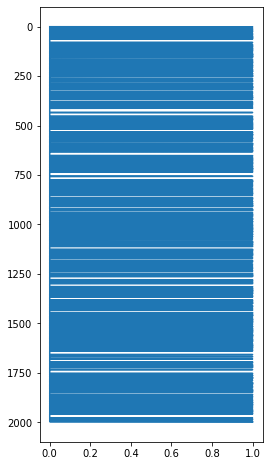

In [64]:
fig = plt.figure(figsize=(4,8))

ax = fig.add_subplot(1,1,1)
ax.plot(lith_sequence, range(0,n_samples))
ax.invert_yaxis()

plt.show()

This is pretty difficult to see what is going on... Zoom in on the first 100 samples

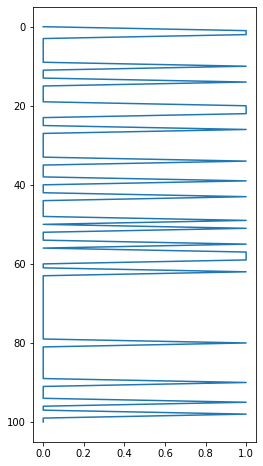

In [65]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(1,1,1)
ax.plot(lith_sequence[0:101], range(0,101))
ax.invert_yaxis()
plt.show()

This looks promising.  However, To make a meaningful display of it using imshow, we need to duplicate the rows

In [70]:
lith = np.array([lith_sequence]*100)

In [71]:
lith

array([[0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1]])

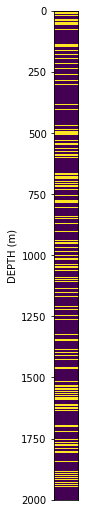

In [72]:
fig = plt.figure(figsize=(4,9))
ax = fig.add_subplot(1,1,1, xticks=(), xticklabels=())
ax.imshow(lith.T)
ax.set_ylabel('DEPTH (m)')
ax.set_ylim(0,2000)
ax.invert_yaxis()
plt.show()

Ok, now we have a synthetic model that looks a plausible representation of the subsurface.

## 2. Define Layered Impedance Model

**First define Vp, Vs, Rhob properties and populate**

In [69]:
Vp_sd = 3032
Vs_sd = 1543
Rhob_sd = 2.17

Vp_sh = 2430
Vs_sh = 919
Rhob_sh = 2.11

In [97]:
rock_props = [Vp_sh, Rhob_sh, Vp_sd, Rhob_sd]

In [98]:
rocks = np.array(rock_props).reshape(2,2)

In [99]:
earth_sequence = rocks[lith_sequence]

In [100]:
earth = rocks[lith]

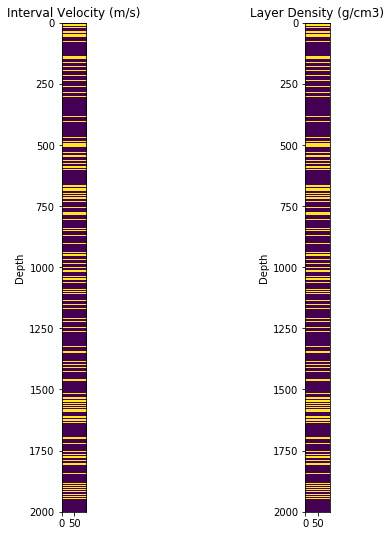

In [101]:
fig = plt.figure(figsize=(8,9))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(earth[:,:,0].T)
ax1.set_ylabel('Depth')
ax1.set_ylim(0, n_samples)
ax1.invert_yaxis()
ax1.set_title('Interval Velocity (m/s)')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(earth[:,:,1].T)
ax2.set_ylabel('Depth')
ax2.set_ylim(0, n_samples)
ax2.invert_yaxis()
ax2.set_title('Layer Density (g/cm3)')

plt.show()

**Calculate the Acoustic Impedance of Each layer**

In [103]:
imp_seq = np.apply_along_axis(np.product, axis=-1, arr=earth_sequence) # axis=-1 because Vp & Rhob are stored in the last axis
imp = np.apply_along_axis(np.product, axis=-1, arr=earth)

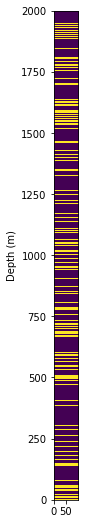

In [109]:
fig = plt.figure(figsize=(4,9))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(imp.T)
ax.set_ylabel('Depth (m)')
ax.set_ylim(0, n_samples)
plt.show()

**Calculate Reflection Coefficient**

$RC = \frac{AI_{2} - AI_{1}}{AI_{2} + AI_{1}}$

In [110]:
rc_seq = (imp_seq[1:] - imp_seq[:-1]) / (imp_seq[1:] + imp_seq[:-1])

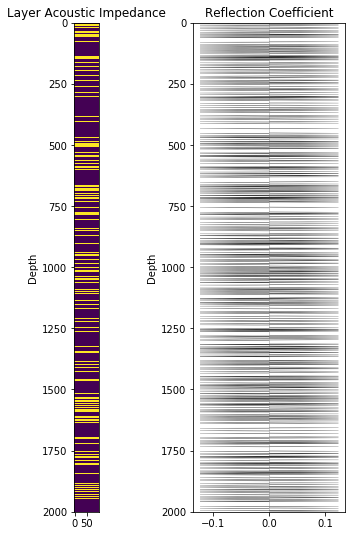

In [119]:
fig = plt.figure(figsize=(6,9))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imp.T)
ax1.set_ylabel('Depth')
ax1.set_ylim(0, n_samples)
ax1.invert_yaxis()
ax1.set_title('Layer Acoustic Impedance')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(rc_seq, range(0,n_samples-1), 'k', lw=0.2)
ax2.set_ylabel('Depth')
ax2.set_ylim(0, n_samples)
ax2.invert_yaxis()
ax2.set_title('Reflection Coefficient')

plt.show()

## 3. Convolve the model with a wavelet to create a synthetic seismic trace

**Design a wavelet**

In [146]:
def wavelet(duration=0.100, dt=0.001, f=25):
    t = np.linspace(-duration / 2, (duration) / 2, int(duration / dt))
    w = (1.0 - 2.0 * (np.pi ** 2) * (f ** 2) * (t ** 2)) * np.exp(-(np.pi ** 2) * (f ** 2) * (t ** 2))
    return t, w

In [147]:
t, ricker25 = wavelet(duration=0.100, dt=0.001, f=25)

plot the wavelet

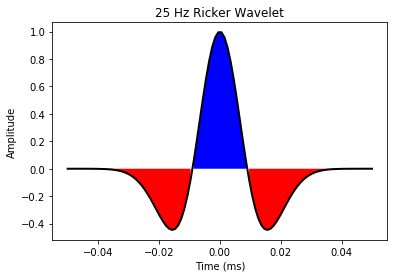

In [152]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(t, ricker25, 'k', lw=2)
ax.fill_between(t, 0, ricker25, where=ricker25>=0, facecolor='blue')
ax.fill_between(t, ricker25, 0, where=ricker25<=0, facecolor='red')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_title('25 Hz Ricker Wavelet')
plt.show()

**Convolve wavelet with Reflection Coefficient**

In [153]:
def convolve(rc, wavelet):
    synth = np.apply_along_axis(lambda t: np.convolve(t, wavelet, mode="same"), axis=0, arr=rc)
    return synth

In [154]:
synth_seis_trace = convolve(rc_seq, ricker25)

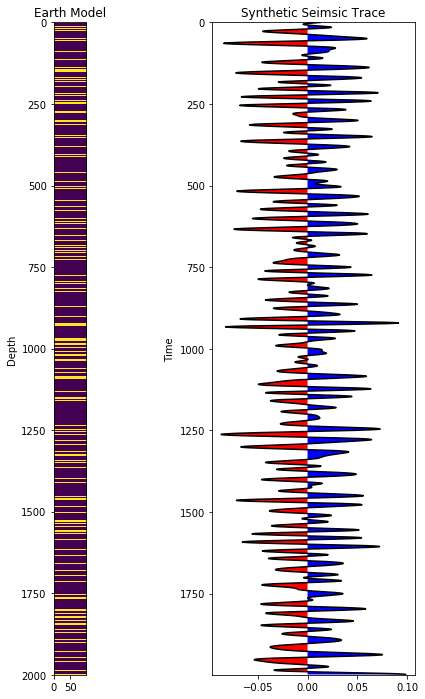

In [158]:
fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(lith.T)
ax1.set_ylim(0, n_samples)
ax1.invert_yaxis()
ax1.set_ylabel('Depth')
ax1.set_title('Earth Model')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(synth_seis_trace, range(0, len(synth_seis_trace)), 'k')
ax2.fill_betweenx(range(0, len(synth_seis_trace)), 0, synth_seis_trace, where=synth_seis_trace<=0, facecolor='red')
ax2.fill_betweenx(range(0, len(synth_seis_trace)), 0, synth_seis_trace, where=synth_seis_trace>=0, facecolor='blue')
ax2.set_ylim(0, len(synth_seis_trace))
ax2.invert_yaxis()
ax2.set_ylabel('Time')
ax2.set_title('Synthetic Seimsic Trace')

plt.show()

Add some random white noise to the synthetic trace to make it more like a field record

In [163]:
agw = rng.normal(0, 1, synth_seis_trace.shape)
agw = np.interp(agw, (agw.min(), agw.max()), (synth_seis_trace.min(), synth_seis_trace.max())) 
synth_seis_trace_agw = synth_seis_trace + agw

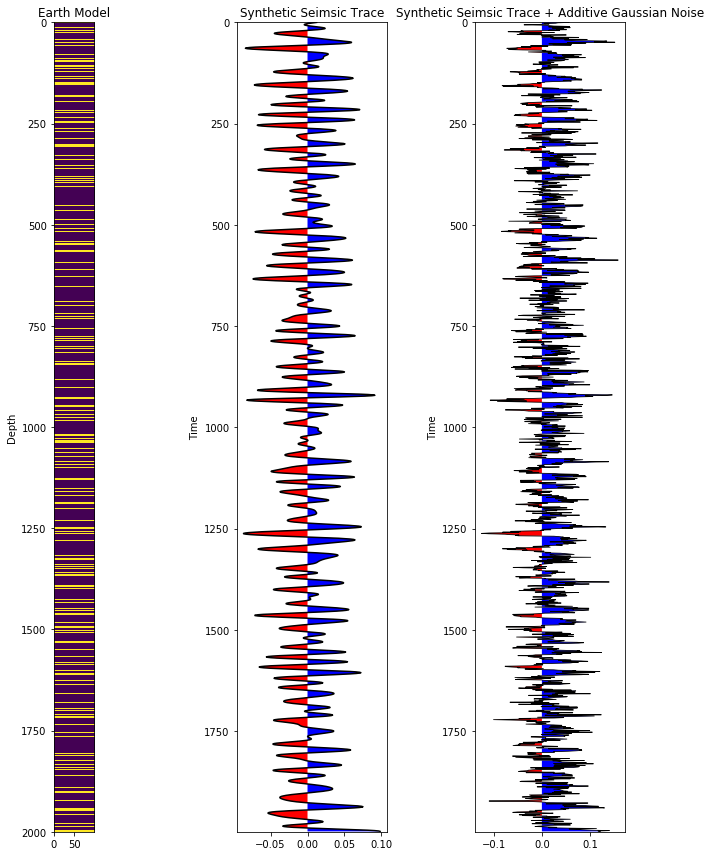

In [172]:
fig = plt.figure(figsize=(10,12))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(lith.T)
ax1.set_ylim(0, n_samples)
ax1.invert_yaxis()
ax1.set_ylabel('Depth')
ax1.set_title('Earth Model')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(synth_seis_trace, range(0, len(synth_seis_trace)), 'k')
ax2.fill_betweenx(range(0, len(synth_seis_trace)), 0, synth_seis_trace, where=synth_seis_trace<=0, facecolor='red')
ax2.fill_betweenx(range(0, len(synth_seis_trace)), 0, synth_seis_trace, where=synth_seis_trace>=0, facecolor='blue')
ax2.set_ylim(0, len(synth_seis_trace))
ax2.invert_yaxis()
ax2.set_ylabel('Time')
ax2.set_title('Synthetic Seimsic Trace')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(synth_seis_trace_agw, range(0, len(synth_seis_trace_agw)), 'k', lw=0.8)
ax3.fill_betweenx(range(0, len(synth_seis_trace_agw)), 0, synth_seis_trace_agw, where=synth_seis_trace_agw<=0, facecolor='red')
ax3.fill_betweenx(range(0, len(synth_seis_trace_agw)), 0, synth_seis_trace_agw, where=synth_seis_trace_agw>=0, facecolor='blue')
ax3.set_ylim(0, len(synth_seis_trace_agw))
ax3.invert_yaxis()
ax3.set_ylabel('Time')
ax3.set_title('Synthetic Seimsic Trace + Additive Gaussian Noise')

plt.tight_layout()
plt.show()